In [1]:
import pandas as pd 
import numpy as np 
import ast
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

In [2]:
df1=pd.read_csv('data/tmdb_5000_credits.csv')
df2=pd.read_csv('data/tmdb_5000_movies.csv')

### Visualizando a Base de Dados

In [3]:
df1.head(5)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [4]:
df2.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [5]:
df = pd.merge(
    df2, df1.drop(['title'], axis=1),
    how='left', left_on = 'id', right_on = 'movie_id'
).drop(['movie_id'], axis=1)

In [6]:
df.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [7]:
df.dtypes

budget                    int64
genres                   object
homepage                 object
id                        int64
keywords                 object
original_language        object
original_title           object
overview                 object
popularity              float64
production_companies     object
production_countries     object
release_date             object
revenue                   int64
runtime                 float64
spoken_languages         object
status                   object
tagline                  object
title                    object
vote_average            float64
vote_count                int64
cast                     object
crew                     object
dtype: object

### Análise Exploratória - Categóricas

##### Algumas variáveis não serão analisadas;
##### - overview, keywords e tagline: não faremos análise de texto
##### - homepage, original_title, original_language: não usaremos para a recomendação

In [8]:
df_categ = df[[
    'genres', 'production_companies', 'production_countries', 'release_date', 'spoken_languages', 'status', 'cast', 'crew'
]]

In [9]:
df_categ['status'].value_counts()

Released           4795
Rumored               5
Post Production       3
Name: status, dtype: int64

##### vamos filtrar apenas os filmes lançados, pois serão estes os utilizados na recomendação

In [10]:
df_categ = df_categ[df_categ['status'] == 'Released']

##### Alguns campos estão num formato json, para analisá-los vamos tratar esses campos. Em seguida vamos tentar entender a distribuição dos dados. 
##### Informações com menos de 1% de relevância foram agrupados numa nova categoria chamada 'Outros'

In [11]:
def dist_analyse(dataset, col):
    df = dataset[col].fillna('[]').apply(ast.literal_eval)
    df = df.apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []).to_frame()
    df = df.drop(col, 1).join(df[col].str.join('|').str.get_dummies())
    result = df.apply(pd.value_counts).fillna(0).T
    result.reset_index(level=0, inplace=True)
    result = result.sort_values(by=[1], ascending=False) 
    result['repres'] = result[1]/result[1].sum()
    result['index'] = np.where(result['repres'] <=  0.01, 'Outros', result['index'])    
    result = result.groupby(['index'])['repres'].sum().sort_values(ascending=False)
    return result

#### Production_countries

Text(0,0.5,'%')

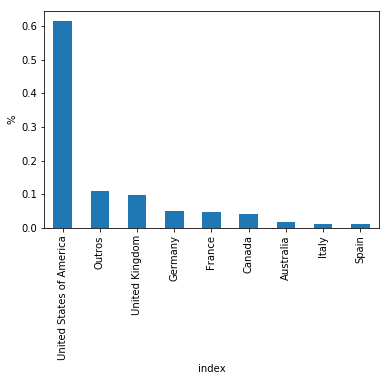

In [12]:
dist_analyse(df_categ, 'production_countries').plot.bar()
plt.ylabel('%')

#### Production_companies

Text(0,0.5,'%')

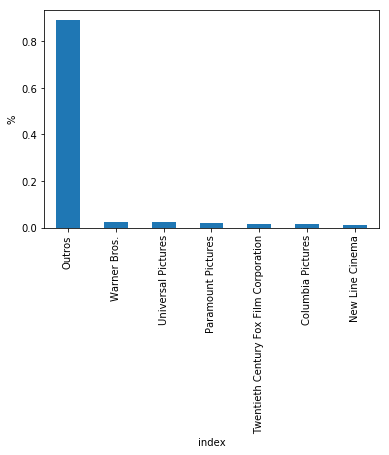

In [13]:
dist_analyse(df_categ, 'production_companies').plot.bar()
plt.ylabel('%')

#### Genres

Text(0,0.5,'%')

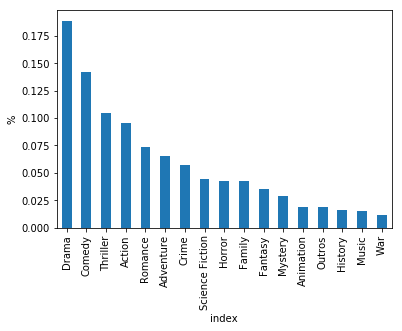

In [14]:
dist_analyse(df_categ, 'genres').plot.bar()
plt.ylabel('%')

##### sem presença de outros quer dizer que nenhuma var fo

#### Spoken Languages

Text(0,0.5,'%')

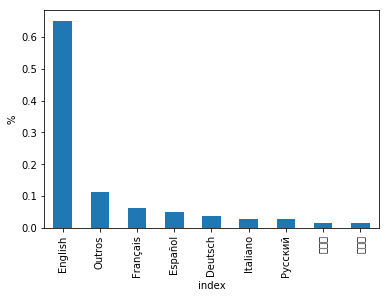

In [15]:
dist_analyse(df_categ, 'spoken_languages').plot.bar()
plt.ylabel('%')

#### Cast e Crew (atores e produção) 
##### Diferente das variáveis analisadas anteriormente, não existe uma distribuição ou algo parecido a ser analisado. Por isso vamos apenas visualizar com mais detalhe como a informação está estruturada
##### Na elaboração da recomendação, trataremos esta informação

In [16]:
teste = df_categ['cast'].fillna('[]').apply(ast.literal_eval)
teste.apply(lambda x: [i['character'] for i in x] if isinstance(x, list) else []).to_frame().head()

,cast
0,"[Jake Sully, Neytiri, Dr. Grace Augustine, Col..."
1,"[Captain Jack Sparrow, Will Turner, Elizabeth ..."
2,"[James Bond, Blofeld, Madeleine, M, Lucia, Q, ..."
3,"[Bruce Wayne / Batman, Alfred Pennyworth, Jame..."
4,"[John Carter, Dejah Thoris, Sola, Tars Tarkas,..."


In [17]:
df_categ['crew'].fillna('[]').apply(ast.literal_eval)[0][:3]

[{'credit_id': '52fe48009251416c750aca23',
  'department': 'Editing',
  'gender': 0,
  'id': 1721,
  'job': 'Editor',
  'name': 'Stephen E. Rivkin'},
 {'credit_id': '539c47ecc3a36810e3001f87',
  'department': 'Art',
  'gender': 2,
  'id': 496,
  'job': 'Production Design',
  'name': 'Rick Carter'},
 {'credit_id': '54491c89c3a3680fb4001cf7',
  'department': 'Sound',
  'gender': 0,
  'id': 900,
  'job': 'Sound Designer',
  'name': 'Christopher Boyes'}]

#### Release Date

Text(0.5,0,'ano de lançamento')

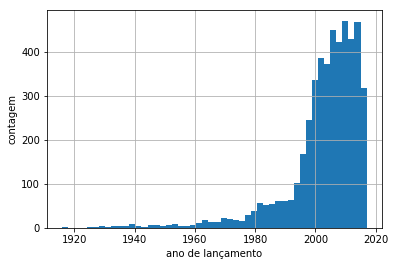

In [18]:
pd.to_datetime(df_categ['release_date']).dt.year.hist(bins = 50)
plt.ylabel('contagem')
plt.xlabel('ano de lançamento')

### Variávies Numéricas

In [19]:
df_num = df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]
df_num.dtypes

budget            int64
popularity      float64
revenue           int64
runtime         float64
vote_average    float64
vote_count        int64
dtype: object

In [20]:
df_num.isnull().sum()

budget          0
popularity      0
revenue         0
runtime         2
vote_average    0
vote_count      0
dtype: int64

In [21]:
df_num = df_num.replace(np.nan, 0)

In [22]:
df_num.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4.803000e+03,4803.000000,4803.000000,4803.000000
mean,2.904504e+07,21.492301,8.226064e+07,106.831355,6.092172,690.217989
std,4.072239e+07,31.816650,1.628571e+08,22.712156,1.194612,1234.585891
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,28.313505,9.291719e+07,117.500000,6.800000,737.000000
max,3.800000e+08,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


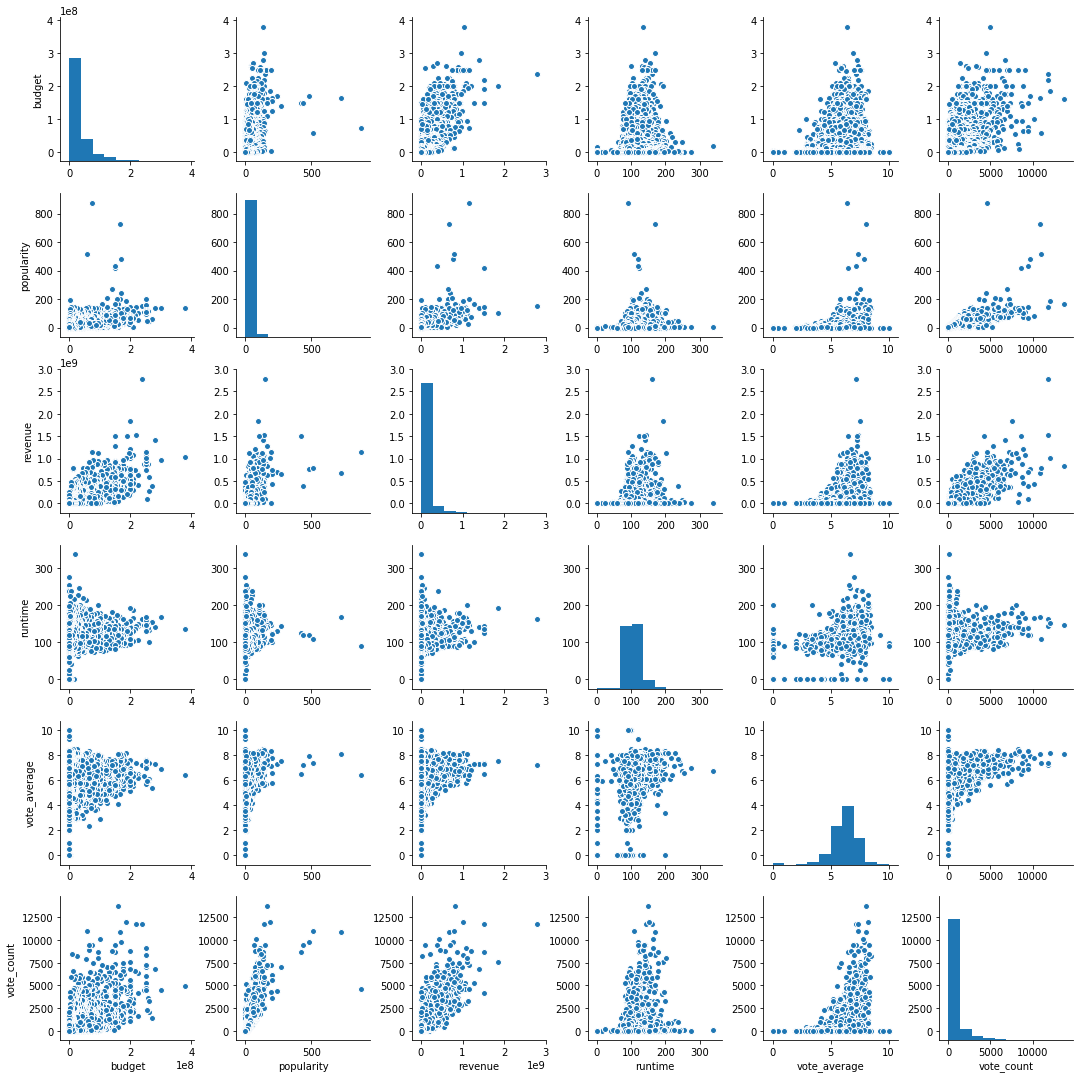

In [24]:
sns.pairplot(df_num[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']])

##### Note que as variáveis parecem não possuir correlação
##### Perceba que as variáveis *'popularity'*, *'revenue'* e *'vote_count'*, parecem possuir um grande preenchimento de zeros, vamos investigar mais detalhadamente.

In [25]:
df_num.apply(lambda column: (column == 0).sum()/len(df_num))

budget          0.215907
popularity      0.000208
revenue         0.297106
runtime         0.007704
vote_average    0.013117
vote_count      0.012909
dtype: float64

#### Popularity

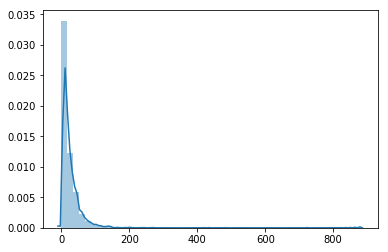

In [26]:
sns.distplot(pd.DataFrame(df_num['popularity']))

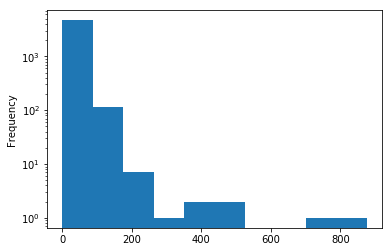

In [27]:
df_num['popularity'].plot.hist(log = True)

#### Revenue

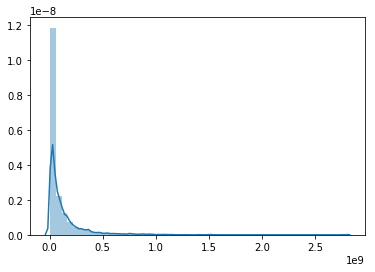

In [28]:
sns.distplot(pd.DataFrame(df_num['revenue']))

##### Parece que os zeros foram ocasionados devido a escala que foi adotada para o plot

#### Vote Count

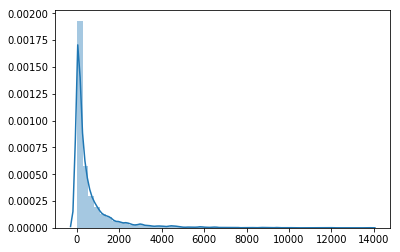

In [30]:
sns.distplot(pd.DataFrame(df_num['vote_count']))

### Cosiderações Finais

##### A escolha das variáveis para o modelo de recomendação será feita sobretudo em função da técnica adotada. No entando podemos considerar 2 pontos de atenção:
##### - production_companies, production_countries, spoken_languages e vote_count: caracteristica de cauda longa, pode dificultar a modelagem
##### - popularidadde: variável aparenta estar com problema em seu preenhimento, pois a distância em escala de valor do percentil 75 e do valor máximo é muito grande. Essa distorção pode acontecer pela presença de outliers ou erros de preenchimento, porém não foi fornecida nenhuma informação adicional sobre a range de valores que a variável aceita.